In [1]:
# ✅ Instalar dependencias (si estás en Google Colab)
!pip install -q xgboost shap scikit-learn pandas matplotlib

# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
shap.initjs()


In [3]:
# 🔄 Simular 5000 clientes con historial de comportamiento
np.random.seed(42)
n_samples = 5000

df = pd.DataFrame({
    'visitas_web': np.random.poisson(5, n_samples),
    'clics_email': np.random.poisson(2, n_samples),
    'dias_ultima_visita': np.random.exponential(10, n_samples),
    'productos_vistos': np.random.randint(1, 20, n_samples),
    'cupon_usado': np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3]),
    'cliente_frecuente': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'segmento': np.random.choice([0, 1, 2], size=n_samples, p=[0.5, 0.3, 0.2])
})

# Lógica de probabilidad de compra (ruido + comportamiento)
probabilidad = (
    0.02 * df['visitas_web'] +
    0.1 * df['clics_email'] +
    -0.01 * df['dias_ultima_visita'] +
    0.03 * df['productos_vistos'] +
    0.2 * df['cupon_usado'] +
    0.1 * df['cliente_frecuente'] +
    0.05 * (df['segmento'] == 2).astype(int) +
    np.random.normal(0, 0.1, n_samples)
)

# Probabilidad a binaria
df['compró'] = (probabilidad > np.percentile(probabilidad, 75)).astype(int)

print("✅ Dataset simulado con variables de comportamiento:")
print(df.head())


✅ Dataset simulado con variables de comportamiento:
   visitas_web  clics_email  dias_ultima_visita  productos_vistos  \
0            5            1            4.360398                19   
1            4            2            3.380243                 4   
2            4            1           19.189825                14   
3            5            2            4.003767                 9   
4            5            2           16.968407                 4   

   cupon_usado  cliente_frecuente  segmento  compró  
0            0                  0         0       0  
1            0                  0         0       0  
2            0                  0         1       0  
3            1                  0         0       0  
4            0                  1         0       0  


In [4]:
# Separar features y target
X = df.drop(columns='compró')
y = df['compró']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Modelo
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Métricas
print("\n📊 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print(f"📈 AUC: {roc_auc_score(y_test, y_proba):.4f}")



📊 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1125
           1       0.79      0.73      0.76       375

    accuracy                           0.88      1500
   macro avg       0.85      0.83      0.84      1500
weighted avg       0.88      0.88      0.88      1500

📈 AUC: 0.9398


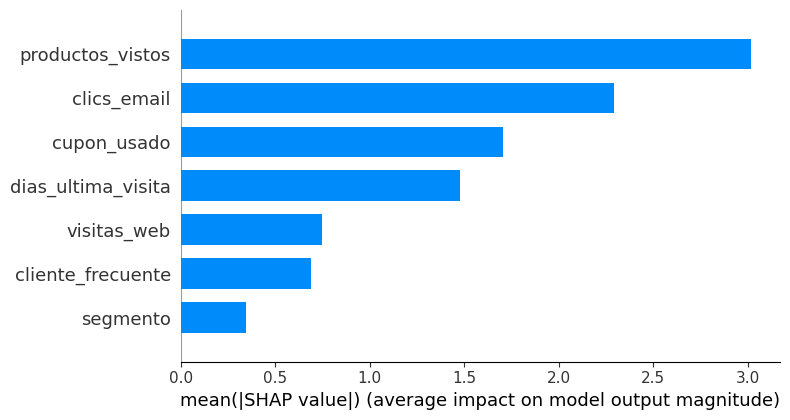

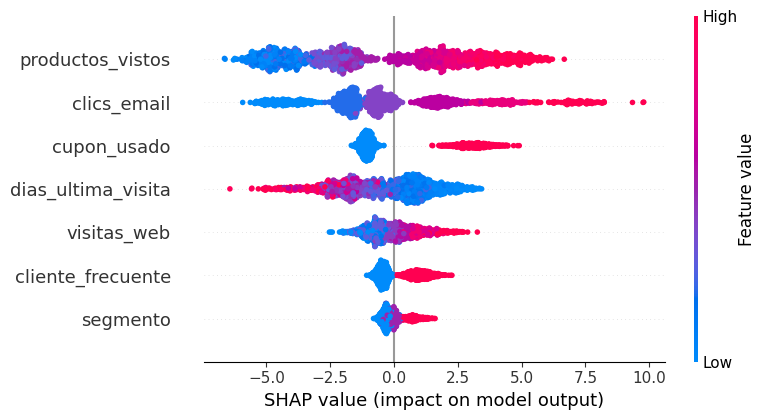

In [5]:
# SHAP values (TreeExplainer para XGBoost)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 🔍 Interpretación global
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)



🧍 Interpretación del cliente #10:


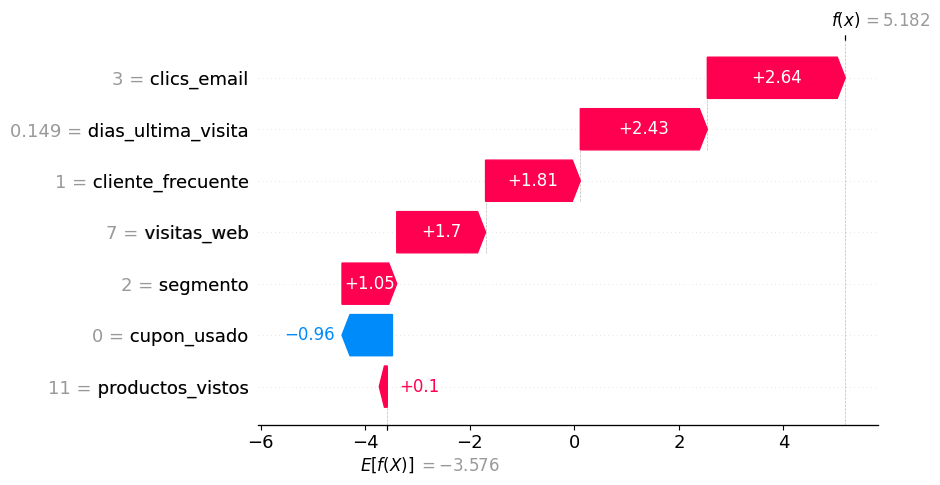

In [6]:
# Ver cliente individual
cliente_idx = 10
print(f"\n🧍 Interpretación del cliente #{cliente_idx}:")
shap.plots.waterfall(shap_values[cliente_idx])


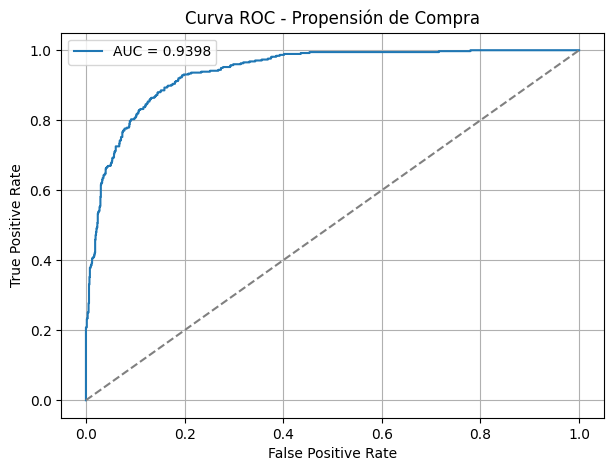

In [7]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Propensión de Compra')
plt.legend()
plt.grid(True)
plt.show()


📌 Umbral óptimo (F1): 0.29 → F1 = 0.7722

📈 Reporte de clasificación optimizada:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1125
           1       0.75      0.80      0.77       375

    accuracy                           0.88      1500
   macro avg       0.84      0.85      0.85      1500
weighted avg       0.89      0.88      0.88      1500

💰 ROI estimado en campaña sobre top 10% más propensos: 14.67x
🎯 Tasa de conversión real del top 10%: 94.00%


 93%|=================== | 1392/1500 [00:17<00:01]       

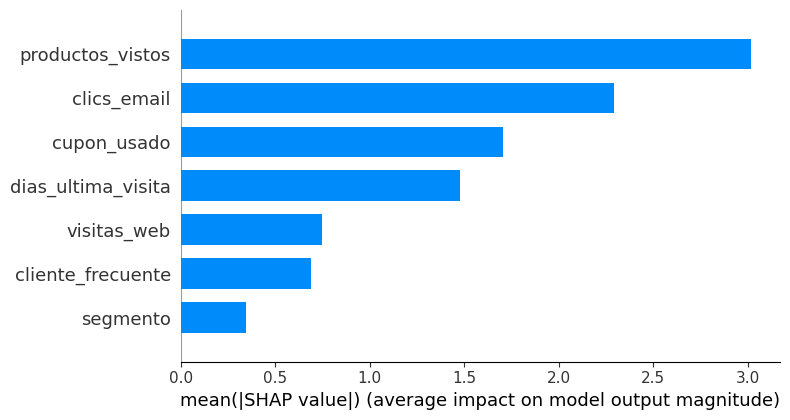


🧍 Interpretación cliente #10


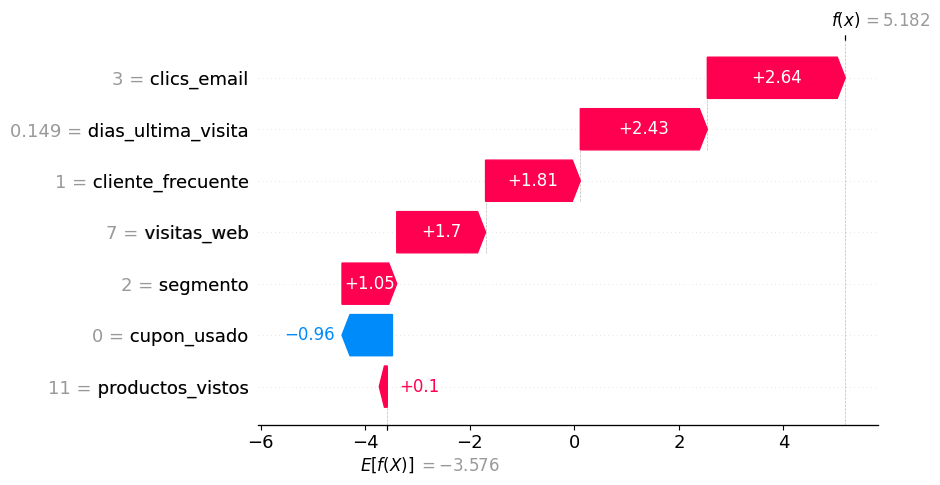


📤 Reporte SHAP exportado: reporte_shap_clientes.csv

📊 Entrenamiento por segmento:
 - Segmento 0: AUC = 0.9469, Clientes = 2464
 - Segmento 1: AUC = 0.9515, Clientes = 1544
 - Segmento 2: AUC = 0.9211, Clientes = 992


In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
import shap

# ========= 1️⃣ Entrenamiento base (reutilizando X, y) =========

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]

# ========= 2️⃣ Optimización de umbral =========
best_threshold = 0.5
best_f1 = 0
for t in np.arange(0.1, 0.9, 0.01):
    y_pred_opt = (y_proba > t).astype(int)
    score = f1_score(y_test, y_pred_opt)
    if score > best_f1:
        best_f1 = score
        best_threshold = t

print(f"📌 Umbral óptimo (F1): {best_threshold:.2f} → F1 = {best_f1:.4f}")
y_final = (y_proba > best_threshold).astype(int)

print("\n📈 Reporte de clasificación optimizada:")
print(classification_report(y_test, y_final))

# ========= 3️⃣ ROI de campaña simulada sobre top 10% =========
top_n = int(len(y_proba) * 0.1)
selected = np.argsort(y_proba)[-top_n:]
conversion_rate = y_test.iloc[selected].mean()

costo_unitario = 1.5
ganancia_unitaria = 25
roi = (conversion_rate * ganancia_unitaria - costo_unitario) / costo_unitario

print(f"💰 ROI estimado en campaña sobre top 10% más propensos: {roi:.2f}x")
print(f"🎯 Tasa de conversión real del top 10%: {conversion_rate:.2%}")

# ========= 4️⃣ Interpretabilidad global e individual =========
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Top variables globales
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Cliente individual
cliente_idx = 10
print(f"\n🧍 Interpretación cliente #{cliente_idx}")
shap.plots.waterfall(shap_values[cliente_idx])

# ========= 5️⃣ Exportar reporte interpretativo =========
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df['cliente_id'] = X_test.index
shap_df['probabilidad_compra'] = y_proba
shap_df['prediccion'] = y_final
shap_df['verdadero'] = y_test.values
shap_df.to_csv("reporte_shap_clientes.csv", index=False)
print("\n📤 Reporte SHAP exportado: reporte_shap_clientes.csv")

# ========= 6️⃣ Entrenar modelo por segmento =========
segmentos = df['segmento'].unique()
print("\n📊 Entrenamiento por segmento:")

for seg in segmentos:
    subset = df[df['segmento'] == seg]
    X_seg = subset.drop(columns='compró')
    y_seg = subset['compró']

    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_seg, y_seg, test_size=0.3, random_state=42)
    model_seg = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model_seg.fit(X_train_s, y_train_s)
    y_proba_s = model_seg.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test_s, y_proba_s)

    print(f" - Segmento {seg}: AUC = {auc:.4f}, Clientes = {len(y_seg)}")
